In [1]:
import numpy as  np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# PyTorch in Venice

*most of this talk is stolen from [Stefan Sotte](https://github.com/sotte/pytorch_tutorial)*


## Outline

1. PyTorch Basics

    1.1. 1D Waves in PyTorch
    
    1.2. Example Networks

2. Predicting Storm Surge in Venice

    2.1. Datasets
    
    2.2. Dataloaders
    
    2.3. Network Models

# 1. PyTorch Basics

### What is it?

* A *dynamic* Deep Learing Library
* Numpy on the GPU

![graph](dynamic_graph.gif)



Super easy to install (including CUDA!):

    conda install pytorch -c pytorch
    


In [2]:
import torch
torch.__version__

'1.0.0.post1001'

## Why I like PyTorch

* made for research (but also production)
* you can just write Python
* feels much simpler than Tensorflow (`tf.Session`, `tf.placeholder`, ...)

In [3]:
import tensorflow as tf

x = tf.random_uniform(shape=[5, 5])
y = tf.random_uniform(shape=[5, 5])
s = x + y
s

<tf.Tensor 'add:0' shape=(5, 5) dtype=float32>

In [4]:
with tf.Session() as sess:
    s_ = sess.run(s)
s_

array([[1.2698461 , 1.0820158 , 1.4225318 , 1.6116196 , 0.8758671 ],
       [1.1471735 , 1.2203801 , 0.54216456, 1.3725866 , 0.9564868 ],
       [1.3976816 , 1.0265735 , 1.0580764 , 1.4211794 , 1.4603329 ],
       [0.34960866, 1.1554592 , 0.9181613 , 1.4740039 , 0.72101736],
       [0.9055518 , 0.8145313 , 1.1107286 , 0.48156536, 1.5289758 ]],
      dtype=float32)

In [5]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
x + y

tensor([[0.5138, 0.0283, 0.5929, 0.8815, 0.5547],
        [1.6078, 1.7584, 0.3873, 1.6351, 1.4020],
        [1.1272, 0.4548, 0.5037, 0.3097, 1.6527],
        [0.5505, 1.0155, 0.9884, 1.8161, 0.7183],
        [0.7269, 1.1200, 1.2554, 0.7633, 0.6202]])

## 1.2. 1D waves in PyTorch

Use it like Numpy!

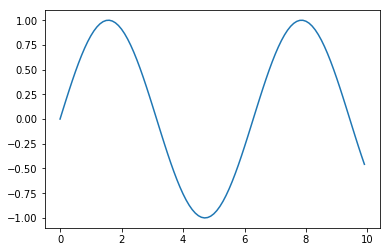

In [6]:
x = torch.arange(0., 10., 0.1)
y = torch.sin(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

In [7]:
def step_1dwave(eta, vel, dt, dx, g, H):
    vel[0] += dt * ( -g * (eta[1] - eta[-1]) / (2 * dx))
    eta[0] += dt * ( -H * (vel[1] - vel[-1]) / (2 * dx))
    vel[-1] += dt * ( -g * (eta[0] - eta[-2]) / (2 * dx))
    eta[-1] += dt * ( -H * (vel[0] - vel[-2]) / (2 * dx))

    for j in range(1, vel.size(0)-1):
        vel[j] += dt * ( -g * (eta[j+1] - eta[j-1]) / (2 * dx))
        eta[j] += dt * ( -H * (vel[j+1] - vel[j-1]) / (2 * dx))
    return eta, vel


def simulate_1dwave(gpts, width, steps):
    g = 9.81
    H = 1.
    L = width
    x = torch.linspace(0., width, gpts)
    dx = x[1] - x[0]

    vel = torch.zeros(gpts, dtype=torch.float)
    eta = torch.sin(2*np.pi*x/L)
    eta = torch.exp(-(50-x)**2/10**2)
    
    ETA = torch.zeros((steps, gpts))
    VEL = torch.zeros_like(ETA)
    for i in tqdm(range(steps)):
        eta, vel = step_1dwave(eta, vel, dt, dx, g, H)
        ETA[i] = eta
        VEL[i] = vel
    return ETA.numpy(), VEL.numpy()

In [8]:
gpts = 200
width = 200.
steps = 200
dt = 0.2

ETA, VEL = simulate_1dwave(gpts, width, steps)

In [9]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_line(lines):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( 0, lines.shape[1]))
    ax.set_ylim((lines.min()-0.1, lines.max()+1.0))

    line, = ax.plot([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)

    # animation function. This is called sequentially
    def animate(i):
        x = np.arange(lines.shape[1])
        line.set_data(x, lines[i])
        return (line,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(lines), interval=20, blit=True)
    return anim

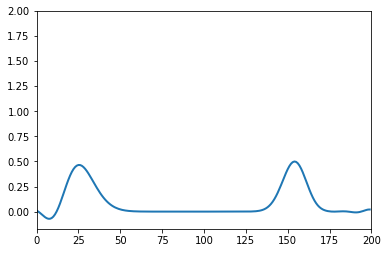

In [10]:
anim = animate_line(ETA)
HTML(anim.to_html5_video())

### Utilize the GPU

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
x = torch.rand(5, 5).to(device)
y = torch.rand(5, 5).to(device)
s = x + y
s.to('cpu')

tensor([[1.2216, 1.1123, 0.5814, 0.7961, 0.7476],
        [1.0852, 1.6419, 0.7492, 0.9925, 0.8076],
        [0.8028, 0.7758, 1.1027, 1.3013, 0.9124],
        [1.1239, 0.8058, 1.3121, 1.0264, 0.6812],
        [1.2704, 1.1113, 1.3567, 0.9054, 0.0794]])

## 1.2. Neural Networks

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict

# Simple sequential model
layers = OrderedDict([
    ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv2d(20,64,5)),
    ('relu2', nn.ReLU())
])
model = nn.Sequential(layers)
model

Sequential(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Random number generator in the forward pass!

In [8]:
class Seq2SeqModel(nn.Module):
    def __init__(self, p_teacher_forcing: float):
        self.p_teacher_forcing = p_teacher_forcing
        # ...

    def forward(self, X, y):
        # ... some calculation
        current_word = torch.zeros(...)
        result = []
        for i in range(self.sentence_length):
            # ... some calculation with current_word
            result.append(output)
            current_word = torch.argmax(output)

            # teacher forcing
            if self.p_teacher_forcing > random.random():
                current_word = y[i]

        return torch.stack(result)

NameError: name 'nn' is not defined